In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams

plt.style.use('ggplot')
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

From the EDA notebook, we found that zipcode 02558 was one of the top 5 zipcodes. We are going to forecast future home values in zipcode 02558 in this notebook.

## Import Data

Import the same data that we used in the EDA notebook.

In [3]:
df = pd.read_csv('zillow_data.csv')

Change RegionName column name to Zipcode for easier read.

In [4]:
df = df.rename(columns={'RegionName': 'Zipcode'})

Created a function to melt the data.

In [5]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'Zipcode', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

Create melted dataframe with just the zipcode 02558.

In [6]:
df_2558 = melt_data(df[df['Zipcode'] == 2558])

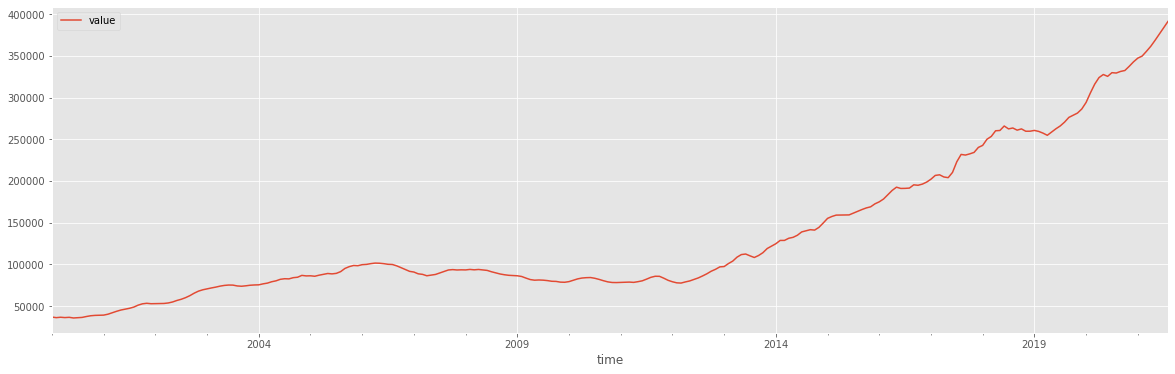

In [7]:
df_2558.plot(figsize=(20,6));

## Baseline Model

For our baseline model, we will take the dataset with just one shift backwards.

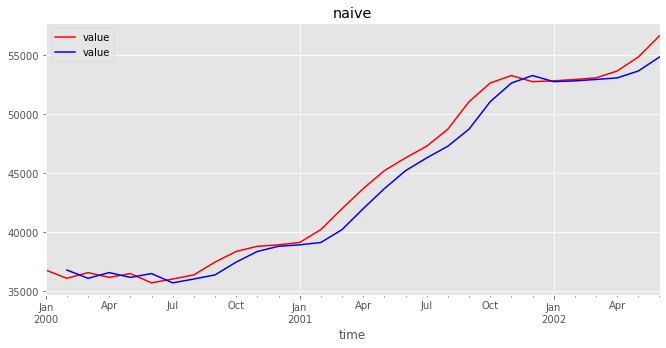

In [8]:
naive = df_2558.shift(1)

fig, ax = plt.subplots(figsize=(11, 5))

df_2558[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [9]:
dftest = adfuller(naive.dropna())
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   3.036318
p-value                          1.000000
#Lags Used                      15.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


From the adfuller test, we can see that our p-value > 0.05. So, we reject our null hypothesis and the model is non-stationary.

## Check seasonality

We can check for trends, seasonality, and residuals using seasonal_decompose function.

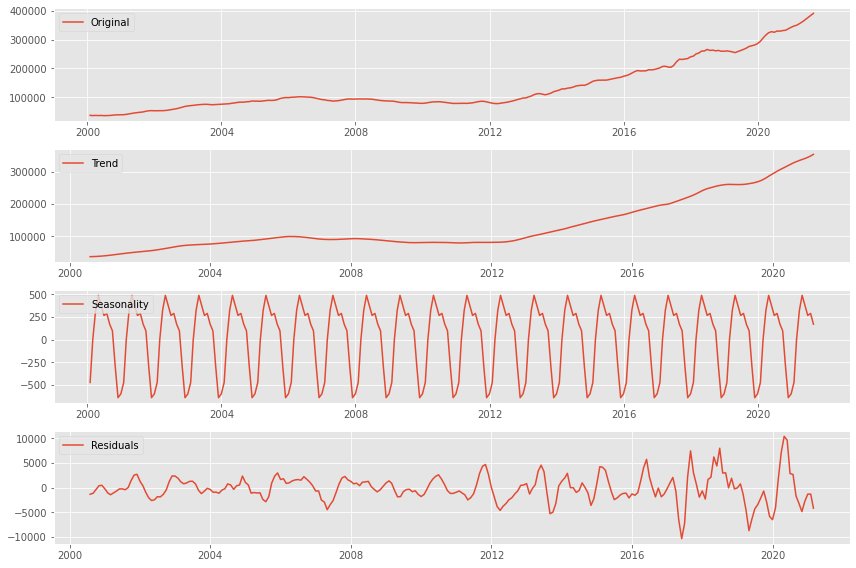

In [10]:
decomposition = seasonal_decompose(df_2558)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_2558, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

The model has an upward trend with seasonality as well.

## Differencing

We want to try to make our models stationary. So, we are going to try to reduce trends/seasonalities fromthe data.

In [11]:
diff = df_2558.diff().dropna()

dftest = adfuller(diff)
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.452923
p-value                          0.900880
#Lags Used                      16.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


First differencing did not make the model be stationary.

Let's try differencing twice.

In [12]:
diff = df_2558.diff().diff().dropna()

dftest = adfuller(diff)
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.140500e+00
p-value                        7.992902e-08
#Lags Used                     1.600000e+01
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


The model is statioanry now since p-value < 0.05.

Let's look at the autocorrelation for this model.

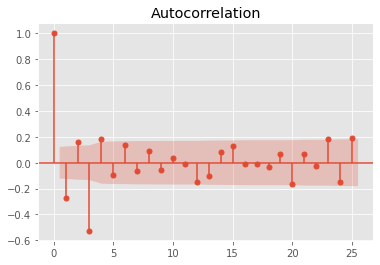

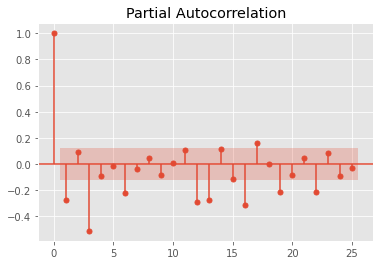

In [13]:
# Autocorrelation Plot
plot_acf(df_2558.diff().diff().dropna());

# Partial Autocorrelation Plot
plot_pacf(df_2558.diff().diff().dropna());

## SARIMAX Model

We are going to use SARIMAX model to model our data.

To get the best hyperparameters for our model, we created a combination of orders and seasonal orders in the range of 0-2, inclusive.

In [13]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [14]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_2558,
                         order=comb,
                         seasonal_order=combs,
                         enforce_stationarity=False,
                         enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6945.726919411753
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =25586.073998553886
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =9815.083876928566
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5680.111023116086
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5361.616047414196
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =5083.3586541848435
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =5286.82737379625
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =4964.659175104311
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =4693.40886945075
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5436.996910992569
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =14645.654208778637
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =5141.65514325268
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5291.414035464193
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5210.303910663821
ARIMA (0, 0, 0) x (1

ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4511.135390231808
ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4281.939052619437
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4372.8780083943875
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4293.8224975723515
ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =4065.591592608544
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4316.129903571211
ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =4137.019856773436
ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3894.06876669961
ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =4334.515087669653
ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =4327.882669264403
ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =4290.678710667911
ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =4139.86142431042
ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =4109.155906401747
ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =4067.109168574766
ARIMA (0, 1, 1) x (2

ARIMA (0, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =4228.159298649193
ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =4178.711450241708
ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =4094.5776687928605
ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =4064.6468117207696
ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3997.4142460455723
ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =4012.376249212193
ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3915.6651485868488
ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3862.899765872011
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4727.184006308147
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4512.483546325615
ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =4367.243932455058
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4730.253510694957
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4420.559758935084
ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =4141.938549815835
ARIMA (1, 0, 0) 

ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =4211.76698694305
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4601.483504648645
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4272.67146438849
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =4024.9510794443495
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4637.528269954357
ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =4277.906897167558
ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3888.7323866409097
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4433.614670305689
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4417.336658708586
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4213.564639564916
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4330.3598964088515
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4265.435510405325
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =4019.583499768569
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4285.56656447185
ARIMA (1, 1, 1) x (1

ARIMA (1, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =4158.143657208509
ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4313.116794415677
ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =4220.3185468239735
ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3979.8706204767773
ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4333.398118970107
ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =4253.011862735574
ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =4014.03559886063
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =4195.017918871637
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =4195.855833049733
ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =4158.250622330881
ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =4058.723208493161
ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =4032.517394458919
ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3996.8279236509015
ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3975.4251743613913
ARIMA (1, 2, 2) x

ARIMA (2, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =4213.347120029161
ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =4051.7157315624945
ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =4032.871416191643
ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =4017.957629168445
ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3964.41583206416
ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3869.357215754029
ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3870.468218088844
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4614.245709538329
ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4411.381817608075
ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =4188.539928769296
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4596.3519181959055
ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4291.538374841119
ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =4056.55724386451
ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4618.2110740090975
ARIMA (2, 1, 1) x (

ARIMA (2, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =4140.717765999255
ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =4568.455435760807
ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =4212.460140403449
ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3964.087158854865
ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =4610.212443025661
ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =4189.460598275912
ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3847.9182313504566
ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =4362.34171201511
ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =4346.131135653586
ARIMA (2, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =4142.379760480484
ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4272.873613612326
ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =4202.143122237814
ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3963.963002904722
ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4308.169865994105
ARIMA (2, 2, 2) x (1

In [15]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 2)
pdqs    (0, 2, 2, 12)
aic       3811.805781
Name: 386, dtype: object

From the combination, our SARIMAX model with order=(1, 1, 2) and seasonal_order=(0, 2, 2, 12) got the lowest aic score, which was 3811.805781.

Now, we can use those hyperparameters for our final model to predict future home values.

In [14]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_2558, 
                                        order=(1, 1, 2), 
                                        seasonal_order=(0, 2, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2065      0.059     -3.507      0.000      -0.322      -0.091
ma.L1          0.8825      0.029     30.386      0.000       0.826       0.939
ma.L2          0.9032      0.028     32.362      0.000       0.848       0.958
ma.S.L12      -1.6290      0.046    -35.695      0.000      -1.718      -1.540
ma.S.L24       0.6681      0.044     15.224      0.000       0.582       0.754
sigma2      3.856e+06   9.08e-09   4.24e+14      0.000    3.86e+06    3.86e+06


From the summary table, we can see that all of the weight has a p-value lower or close to 0.05.

Next, we ran model diagnostics to ensure that none of the assumptions made by the model have been violated.

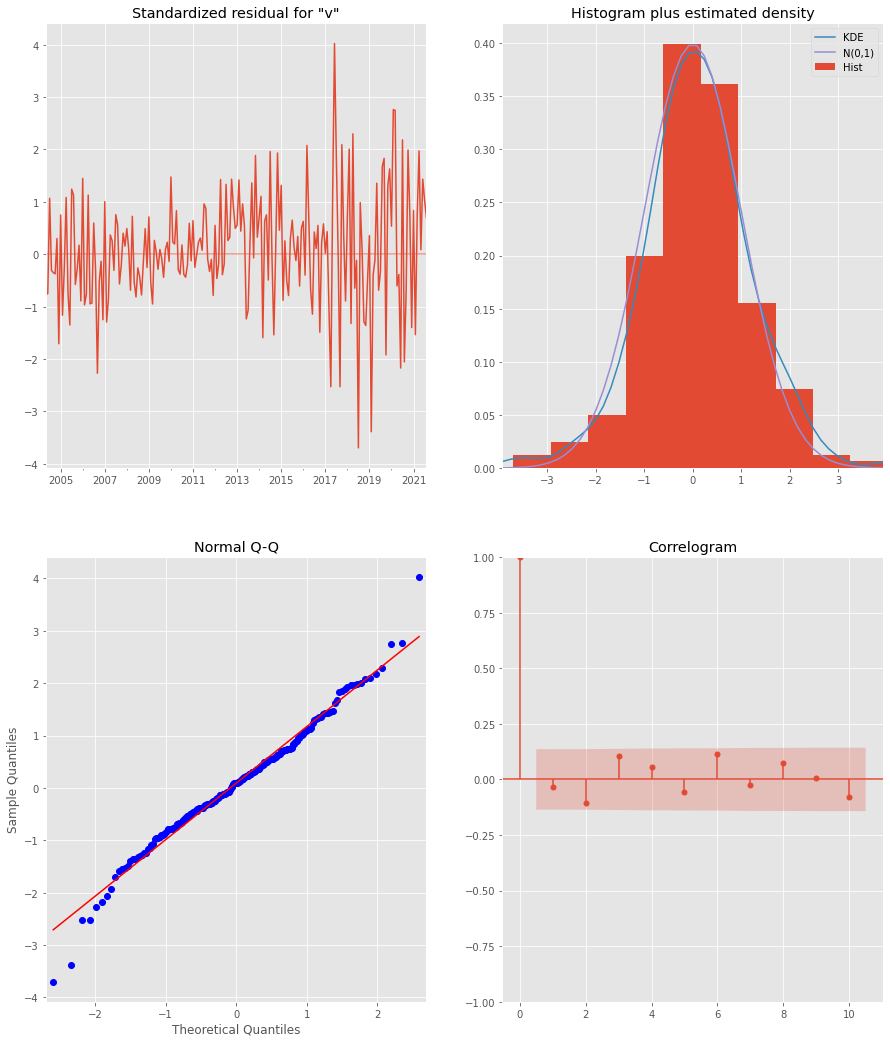

In [15]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

The first plot shows that the residuals are mostly normally distributed. The top right plot shows that the data seems normally distributed. The bottom left plot shows that the residuals follow the linear trend from a standard normal distribution. The bottom right plot shows that the autocorrelation.

### Validating the Model

We will now validate the model by comparing predicted values to real values.

We will validate last two years, starting from 2019-01-31.

In [16]:
# Get predictions starting from 01-31-2019 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=False)
pred_conf = pred.conf_int()

With the predicted values, we can plot the real and forecasted home values.

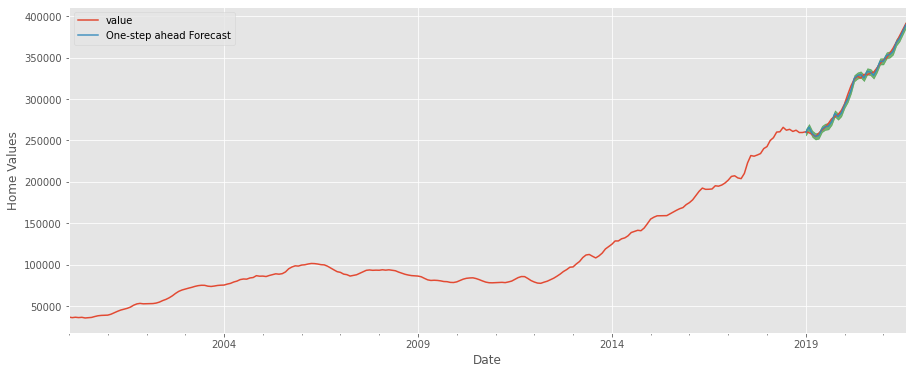

In [17]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_2558.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Values')
plt.legend()

plt.show();

The forecasts align with the true values as seen above, with overall increase trend.

We will check for the accuracy of our forecasts using RMSE (Root Mean Squared Error).

In [18]:
# Get the real and predicted values
value_forecasted = pred.predicted_mean
value_truth = df_2558['value']['2019-01-31':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 3033.62


### Dynamic Forecasting

Let's try to achieve a deep insight by using dynamic forecasts.

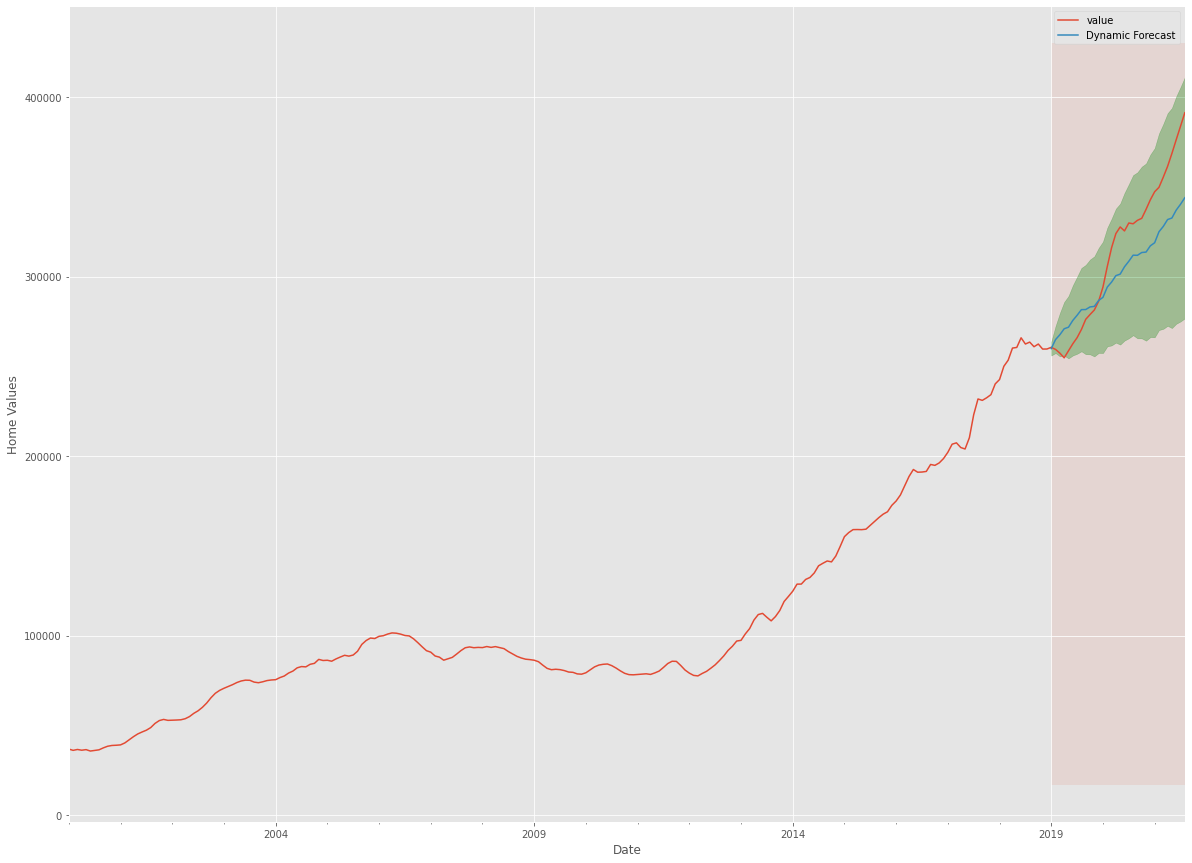

In [19]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.
ax = df_2558.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-01-31'), value_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Home Values')

plt.legend()
plt.show();

In [20]:
# Extract the predicted and true values of our time series
value_forecasted = pred_dynamic.predicted_mean
value_truth = df_2558['value']['2019-01-31':]

# Compute the mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 22334.36


The RMSE score is lower here than what we got before.

## Producing and Visualizing Forecasts

Now, we will forecast future home values

In [21]:
# Get forecast 100 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

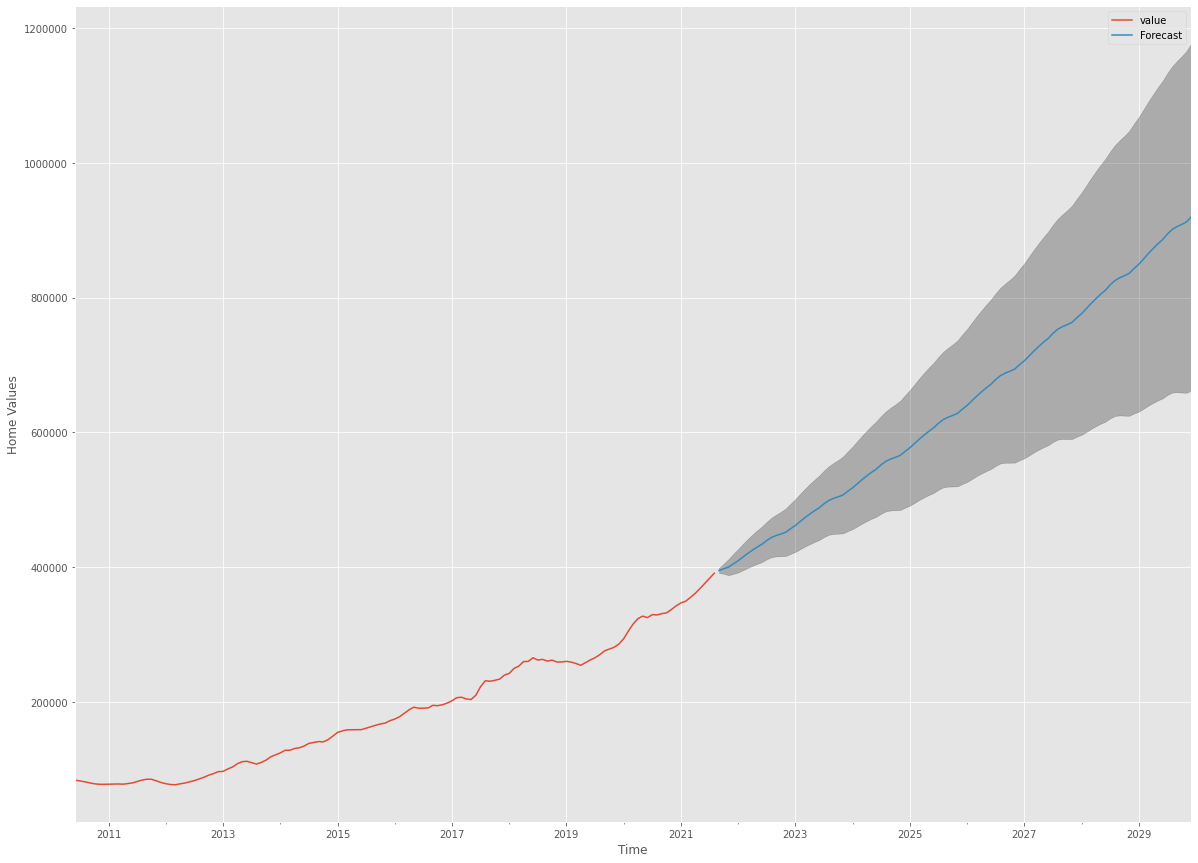

In [22]:
# Plot future predictions with confidence intervals
ax = df_2558.iloc[125:].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Time')
ax.set_ylabel('Home Values')
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.legend()
plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the dataset for zipcode 2558 and foresee what to expect. We get less confident as we go more into the future.